# Imports and Scaffolding

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks/NLP/

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/NLP


In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import gensim
import pickle

import keras
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize, word_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
devices = tf.config.list_physical_devices()
print("Devices: ", devices)

# check if gpu available
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using: {device}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using: cuda
GPU details:  {'compute_capability': (8, 0), 'device_name': 'NVIDIA A100-SXM4-40GB'}


## 1. Data Loading and pre-processing

### 1.1 Load training data from csv

In [4]:
emb_matrix_filepath = "embedding_matrix.obj"

In [5]:
# Load training and test dataset
# train_df = pd.read_csv('data/preprocessed_data/balanced_train.csv')
train_df = pd.read_csv('data/preprocessed_data/train.csv')
test_df = pd.read_csv('data/preprocessed_data/dev.csv')

# print(f"Train set shape: {train_df.shape}")
print(f"Balanced train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

train_df.head()

Balanced train set shape: (8375, 5)
Test set shape: (2094, 5)


,par_id,community,text,label,text_length
0,4341,poor-families,poor-families: The scheme saw an estimated 150...,1,218
1,4136,homeless,homeless: Durban 's homeless communities recon...,1,61
2,10352,poor-families,poor-families: The next immediate problem that...,1,413
3,8279,vulnerable,vulnerable: Far more important than the implic...,1,240
4,1164,poor-families,poor-families: To strengthen child-sensitive s...,1,319


### 1.2. Word Embeddings with Word2Vec

In [6]:
# 1. Define word embeddings using word2vec
# Pre-trained Word2Vec model used in the paper
# Download from: https://code.google.com/archive/p/word2vec/ (GoogleNews-vectors-negative300.bin.gz)

# word2vec = gensim.downloader.load('word2vec-google-news-300')
word2vec = gensim.models.KeyedVectors.load_word2vec_format("models/GoogleNews-vectors-negative300.bin.gz", binary=True)

vocab = list(word2vec.key_to_index)
vocab_size = len(vocab)
word_embedding_len = 300

print("Vocabulary size:", vocab_size)
print("First 10 vocabulary words:", vocab[:10])
print("Length of embeddings:", word_embedding_len)
# print("Word embedding for 'hopeless':", word2vec['hopeless'])

Vocabulary size: 3000000
First 10 vocabulary words: ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']
Length of embeddings: 300


### 1.3. Tokenize data

In [7]:
# 1. Tokenize and prepare training data
def tokenize_data(df, includes_labels=True):
    # split composite words with - and /
    sentences = df['text'].apply(lambda x: x.replace("-", " ").replace("/", " "))
    tokenized_sentences = sentences.apply(nltk.word_tokenize)

    if includes_labels:
        tokenized_df = pd.DataFrame({'tokenized_text': tokenized_sentences, 'label': df['label']})
    else:
        tokenized_df = pd.DataFrame({'tokenized_text': tokenized_sentences})
    return tokenized_df

def get_emb_indices(tokens, vocab_keys, vocab_dict):
    emb_indices = [vocab_keys.index(word) for word in tokens if word in vocab_dict.keys()]
    return emb_indices

def pad_emb_sequences(sequences, max_text_len):
    padded_seqs = pad_sequences(sequences, maxlen=max_text_len, padding='post', truncating='post')[0]
    return padded_seqs

In [27]:
# Create word embeddings and vocabulary from data

# 1.1. Tokenize paragraphs
tokenized_train = tokenize_data(train_df)
# tokenized_test = tokenize_data(test_df)

# train_words = tokenize_data(train_df)['tokenized_text']
# test_words = test_df['text'].apply(lambda x: x.replace("-", " ").replace("/", " ")).apply(nltk.word_tokenize)
unique_tokens = tokenized_train['tokenized_text'].tolist() # + tokenized_test['tokenized_text'].tolist()

In [9]:
# 1.2. Vocabulary and OOV tokens
tokens = list(set(np.concatenate(unique_tokens)))
print("Unique words:", len(tokens))

oov = []
# dictionary of word:embedding
vocab_dict = {}
vocab_dict[""] = np.zeros(300)
vocab_dict["[UNK]"] = np.zeros(300) # unknown words
for token in tokens:
    if token in word2vec:
        vocab_dict[token] = word2vec[token]
    else:
        oov.append(token)

vocab_size = len(vocab_dict)
vocab_keys = list(vocab_dict)
print("Known words:", vocab_size-2)
print("Unknown words:", len(oov))

Unique words: 31080
Known words: 28251
Unknown words: 2829


In [10]:
# Create an embedding matrix of shape (vocab_size, embedding_dim)
embedding_matrix = np.zeros((vocab_size, word_embedding_len))
for word in vocab_dict.keys():
    embedding_matrix[vocab_keys.index(word)] = vocab_dict[word]
embedding_matrix = torch.from_numpy(embedding_matrix)

print("Embedding matrix shape:", embedding_matrix.shape)

print(f"Saving Matrix at {emb_matrix_filepath}...", end='')
pklobj = open(emb_matrix_filepath,"wb")
pickle.dump(embedding_matrix, pklobj)
pklobj.close()
print("Done.")

Embedding matrix shape: torch.Size([28253, 300])
Saving Matrix at embedding_matrix.obj...Done.


Max sentence length: 921 at position 7489


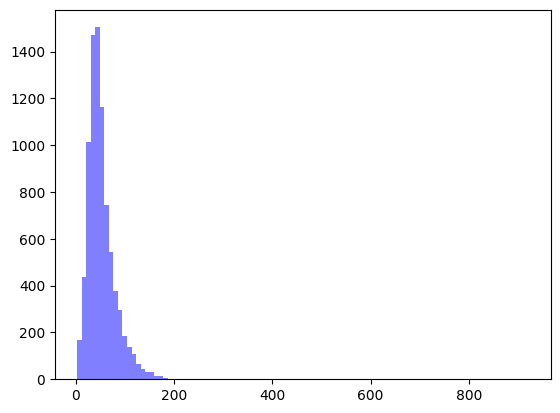

In [28]:
text_lengths = tokenized_train['tokenized_text'].apply(len)
outlier_id = list(text_lengths).index(max(text_lengths))
print("Max sentence length:", max(text_lengths), 'at position', outlier_id)

from matplotlib import pyplot as plt
plt.hist(text_lengths, bins=100, color='b', alpha=0.5)
plt.hist([l for l in text_lengths if l > 190], bins=100, color='r')
plt.show()

There are 5 outlier sentences with lengths >> 200, we can remove them to have smaller padded embedding sizes and use less padding.

Before cleaning (training): 8375
After cleaning (training): 8365
Max sentence length: 197 at position 1237


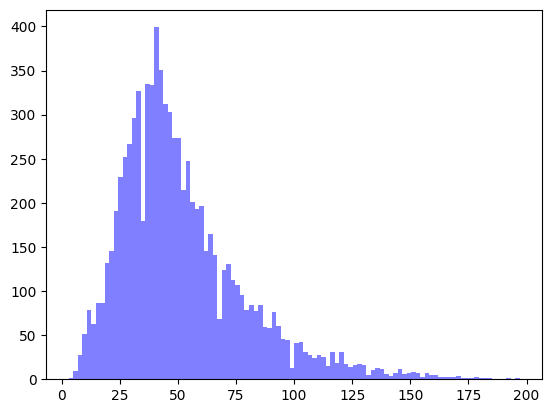

In [29]:
def get_outlier_ids(df, threshold=200):
    text_lengths = list(df['tokenized_text'].apply(len))
    outlier_ids = [text_lengths.index(l) for l in text_lengths if l > threshold]
    return outlier_ids

print("Before cleaning (training):", len(tokenized_train))
tokenized_train = tokenized_train.drop(get_outlier_ids(tokenized_train)) # remove 5
print("After cleaning (training):", len(tokenized_train))

text_lengths = tokenized_train['tokenized_text'].apply(len)
outlier_id = list(text_lengths).index(max(text_lengths))
print("Max sentence length:", max(text_lengths), 'at position', outlier_id)

plt.hist(text_lengths, bins=100, color='b', alpha=0.5)
plt.show()

In [30]:
# 1. Train Data
print("Train Dataset")
print("Before processing:")
print("   Input shape:", train_df['text'].shape)
print("   Labels:", train_df['label'].shape)

# 1.1. Tokenize paragraphs
# tokenized_train = tokenize_data(train_df, includes_labels=True)
max_text_len = max(tokenized_train['tokenized_text'].apply(len))
print("\nPadded sentence length:", max_text_len)

# 1.2. Pad and index tokens
tokenized_train['emb_indices'] = tokenized_train['tokenized_text'].apply(lambda x: get_emb_indices(x, vocab_keys, vocab_dict))
padded_train_emb = pad_sequences(tokenized_train['emb_indices'].values, max_text_len, padding='post', truncating='post')

print("\nAfter processing:")
print("   Input shape:", padded_train_emb.shape)
print("   Labels:", tokenized_train['label'].shape)

Train Dataset
Before processing:
   Input shape: (8375,)
   Labels: (8375,)

Padded sentence length: 197

After processing:
   Input shape: (8365, 197)
   Labels: (8365,)


In [31]:
# 2. Test Data
print("Test Dataset")
print("Before processing:")
print("   Input shape:", test_df['text'].shape)
print("   Labels:", test_df['label'].shape)

# 1.1. Tokenize paragraphs
tokenized_test = tokenize_data(test_df, includes_labels=True)
# print("\nPadded sentence length:", max_text_len)

# tokenized_test = tokenized_test.drop(get_outlier_ids(tokenized_test))
# print("After cleaning (training):", len(tokenized_train), "(test):", len(tokenized_test))

# 1.2. Pad and index tokens
tokenized_test['emb_indices'] = tokenized_test['tokenized_text'].apply(lambda x: get_emb_indices(x, vocab_keys, vocab_dict))
# padded_test_emb = pad_sequences(tokenized_test['emb_indices'].values, max_text_len, padding='post', truncating='post')
padded_test_emb = tokenized_test['emb_indices'].values

print("\nAfter processing:")
print("   Input shape:", padded_test_emb.shape)
print("   Labels:", tokenized_test['label'].shape)

Test Dataset
Before processing:
   Input shape: (2094,)
   Labels: (2094,)

After processing:
   Input shape: (2094,)
   Labels: (2094,)


In [32]:
# 2. Official Dev Data
official_test_df = pd.read_csv('./data/test.tsv', sep='\t', header=None, names=['article_id', 'par_id', 'community', 'country', 'text'])

print("Official Test Dataset")
print("Before processing:")
print("   Input shape:", official_test_df['text'].shape)

# 1.1. Tokenize paragraphs
tokenized_dev = tokenize_data(official_test_df, includes_labels=False)
# print("\nPadded sentence length:", max_text_len)

# tokenized_dev = tokenized_dev.drop(get_outlier_ids(tokenized_dev))
# print("After cleaning (training):", len(tokenized_train), "(test):", len(tokenized_dev))

# 1.2. Pad and index tokens
tokenized_dev['emb_indices'] = tokenized_dev['tokenized_text'].apply(lambda x: get_emb_indices(x, vocab_keys, vocab_dict))
# padded_dev_emb = pad_sequences(tokenized_dev['emb_indices'].values, max_text_len, padding='post', truncating='post')
padded_dev_emb = tokenized_dev['emb_indices'].values

print("\nAfter processing:")
print("   Input shape:", padded_dev_emb.shape)

Test Dataset
Before processing:
   Input shape: (3832,)

After processing:
   Input shape: (3832,)


## 2. BiLSTM model

Reproduces as closely as possible the BiLSTM model in the [original paper](../data/resources/Task_Paper.pdf), with:

* Word2Vec embeddings of dimension 300
* 20 units for each LSTM layer
* dropout rate of 0.25% at both the LSTM and classification layers.
* 300 training epochs
* Adam optimizer with early stopping
* patience of 10 epochs

### 2.1 Model architecture

In [8]:
emb_matrix_filepath = "embedding_matrix.obj"
print("Loading Matrix from ", emb_matrix_filepath, "...", end='')
pklobj = open(emb_matrix_filepath,"rb")
embedding_matrix = pickle.load(pklobj)
pklobj.close()
pklobj.close()
print("Done.")

vocab_size = embedding_matrix.shape[0]
word_embedding_len = embedding_matrix.shape[1]

Loading Matrix from  embedding_matrix.obj ...Done.


In [33]:
# Define the model
def create_model(vocab_size, embedding_dim, max_text_len, embedding_matrix, out_dim=1, dropout=0.0025):
    model = Sequential()
    model.add(Input(shape=(max_text_len,), dtype='int64', name='Input_Layer'))
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=word_embedding_len,
                        weights=[embedding_matrix],
                        trainable=False, name='Word_Embeddings'),)

    # Bidirectional LSTM layer with 20 units each and dropout of 0.25%
    model.add(Bidirectional(LSTM(20, return_sequences=True, dropout=dropout), name='LSTM_1')) #recurrent_dropout
    model.add(Bidirectional(LSTM(20, return_sequences=False, dropout=dropout), name='LSTM_2'))


    # Classification layers
    model.add(Dense(out_dim, activation='sigmoid', name='Output_Layer')) #, activation='softmax'

    # Adam optimizer
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(vocab_size, word_embedding_len, max_text_len, embedding_matrix, 1, 0.25)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Word_Embeddings (Embedding)          │ (None, 197, 300)            │       8,475,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_1 (Bidirectional)               │ (None, 197, 40)             │          51,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_2 (Bidirectional)               │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,537,061 (32.57 MB)

 Trainable params: 61,161 (238.91 KB)

 Non-trainable params: 8,475,900 (32.33 MB)

## 2.1.1 Binary Labels

In [34]:
train_seqs, val_seqs, split_train_labels, val_labels = train_test_split(padded_train_emb, tokenized_train['label'], test_size=0.2, random_state=42)
print("Training split:", train_seqs.shape, "\nValidation split:", val_seqs.shape)

train_seqs = np.array(train_seqs.tolist())
val_seqs = np.array(val_seqs.tolist())

# Train the model
batch_size = 32
epochs = 300

# 1. Training
early_stopping = EarlyStopping(monitor='loss', patience=10) #, restore_best_weights=True)

train_perf = model.fit(train_seqs, split_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Training split: (6692, 197) 
Validation split: (1673, 197)
Epoch 1/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9024 - loss: 0.3658
Epoch 2/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9016 - loss: 0.2969
Epoch 3/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9093 - loss: 0.2644
Epoch 4/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9033 - loss: 0.2887
Epoch 5/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9065 - loss: 0.2628
Epoch 6/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9057 - loss: 0.2470
Epoch 7/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9126 - loss: 0.2415
Epoch 8/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9147 - loss: 0.2248
Epoch 9/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9149 - loss: 0.2216
Epoch 10/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9143 - loss: 0.2262
Epoch 11/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - ac

In [35]:
# 2. Evaluate
train_data = np.array(padded_train_emb.tolist())
train_labels = np.array(tokenized_train['label'].tolist())

model.evaluate(padded_train_emb, train_labels)

262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9420 - loss: 0.3546


[0.1224721297621727, 0.9775254130363464]

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1506
           1       0.46      0.31      0.37       167

    accuracy                           0.89      1673
   macro avg       0.69      0.63      0.65      1673
weighted avg       0.88      0.89      0.88      1673

Dev Set Accuracy: 0.8942020322773461
Dev Set Precision: 0.45535714285714285
Dev Set Recall: 0.30538922155688625
Dev Set F1 Score: 0.3655913978494624

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      1506
           1       0.46      0.31      0.37       167

    accuracy                           0.89      1673
   macro avg       0.69      0.63      0.65      1673
weighted avg       0.88      0.89      0.88      1673



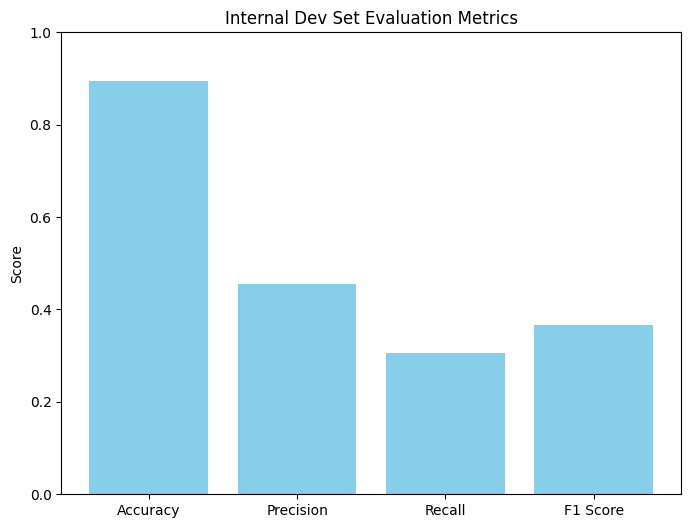

In [50]:
# 2. Test on Validation Dataset
val_preds = model.predict(val_seqs, verbose=1)
val_preds = (val_preds.flatten() > 0.5).astype(np.int32) # np.argmax(test_labels, axis=1)
val_labels = val_labels.values

print(classification_report(val_labels, val_preds))

import matplotlib.pyplot as plt

# Evaluation Metrics on Test Set
accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds)
recall = recall_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)

print("Dev Set Accuracy:", accuracy)
print("Dev Set Precision:", precision)
print("Dev Set Recall:", recall)
print("Dev Set F1 Score:", f1)
print("\nClassification Report:\n", classification_report(val_labels, val_preds))

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1 }

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Internal Dev Set Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1895
           1       0.45      0.32      0.37       199

    accuracy                           0.90      2094
   macro avg       0.69      0.64      0.66      2094
weighted avg       0.88      0.90      0.89      2094

Dev Set Accuracy: 0.897803247373448
Dev Set Precision: 0.44680851063829785
Dev Set Recall: 0.3165829145728643
Dev Set F1 Score: 0.37058823529411766

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      1895
           1       0.45      0.32      0.37       199

    accuracy                           0.90      2094
   macro avg       0.69      0.64      0.66      2094
weighted avg       0.88      0.90      0.89      2094



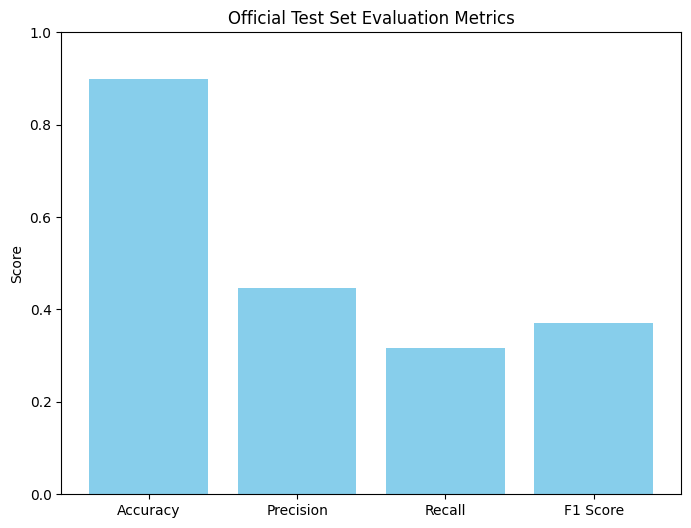

In [51]:
# 3. Test Dataset
test_text_len = max(tokenized_test['tokenized_text'].apply(len))
padded_test_emb = pad_sequences(tokenized_test['emb_indices'].values, test_text_len, padding='post', truncating='post')
test_data = np.array(padded_test_emb.tolist())
test_labels = np.array(tokenized_test['label'].tolist())

test_preds = model.predict(test_data, verbose=1)
test_preds = (test_preds > 0.5).astype(np.int32) # np.argmax(test_labels, axis=1)

# print(classification_report(test_labels, test_preds))

import matplotlib.pyplot as plt

# Evaluation Metrics on Test Set
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print("Dev Set Accuracy:", accuracy)
print("Dev Set Precision:", precision)
print("Dev Set Recall:", recall)
print("Dev Set F1 Score:", f1)
print("\nClassification Report:\n", classification_report(test_labels, test_preds))

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1 }

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Official Test Set Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()

In [53]:
# 4. Official Dev Predictions
from collections import Counter
dev_text_len = max(tokenized_dev['tokenized_text'].apply(len))
padded_dev_emb = pad_sequences(tokenized_dev['emb_indices'].values, dev_text_len, padding='post', truncating='post')
dev_data = np.array(padded_dev_emb.tolist())
dev_preds = model.predict(dev_data, verbose=1)
dev_preds = (dev_preds > 0.5).astype(np.int32)

# Helper function to save predictions
def labels2file(p, outf_path):
    with open(outf_path, 'w') as outf:
        for pi in p:
            outf.write(','.join([str(k) for k in pi]) + '\n')

# Save dev set predictions as dev.txt
labels2file([k for k in dev_preds], 'bilstm_dev.txt')

!cat bilstm_dev.txt | head -n 10

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
0
0
0
0
0
0
0
0
0
0


## 2.1.2 One-Hot encoded Labels

In [54]:
model_one_hot = create_model(vocab_size, word_embedding_len, max_text_len, embedding_matrix, 2, 0.0025)
model_one_hot.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Word_Embeddings (Embedding)          │ (None, 197, 300)            │       8,475,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_1 (Bidirectional)               │ (None, 197, 40)             │          51,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_2 (Bidirectional)               │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 2)                   │              82 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,537,102 (32.57 MB)

 Trainable params: 61,202 (239.07 KB)

 Non-trainable params: 8,475,900 (32.33 MB)

In [55]:
train_labels_one_hot = torch.nn.functional.one_hot(torch.tensor(np.array(tokenized_train['label'])))
print("One Hot ecnoded labels", train_labels_one_hot.shape)
train_seqs, val_seqs, split_train_labels, val_labels = train_test_split(padded_train_emb, train_labels_one_hot, test_size=0.2, random_state=42)
print("Training split:", train_seqs.shape, "\nValidation split:", val_seqs.shape)

train_seqs = np.array(train_seqs.tolist())
val_seqs = np.array(val_seqs.tolist())

# Train the model
batch_size = 32
epochs = 300

# 1. Training
early_stopping = EarlyStopping(monitor='loss', patience=10) #, restore_best_weights=True)

train_perf = model_one_hot.fit(train_seqs, split_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

One Hot ecnoded labels torch.Size([8365, 2])
Training split: (6692, 197) 
Validation split: (1673, 197)
Epoch 1/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8732 - loss: 0.4028
Epoch 2/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9075 - loss: 0.2928
Epoch 3/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9026 - loss: 0.2737
Epoch 4/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9091 - loss: 0.2346
Epoch 5/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9112 - loss: 0.2123
Epoch 6/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9246 - loss: 0.1990
Epoch 7/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9230 - loss: 0.1969
Epoch 8/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9260 - loss: 0.1866
Epoch 9/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9335 - loss: 0.1658
Epoch 10/300
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9415 - loss: 0.1431
Epoch 11/300
21

In [56]:
# 2. Evaluate
model_one_hot.evaluate(padded_train_emb, split_train_labels)

262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9510 - loss: 0.3770


[0.1423957645893097, 0.9794381260871887]

In [72]:
split_train_labels

tensor([[0, 1],
        [1, 0],
        [1, 0],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]])

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Dev Set Accuracy: 0.8971906754333533
Dev Set Precision: 0.7112009542712437
Dev Set Recall: 0.6713704065971643
Dev Set F1 Score: 0.6884143670608849

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1506
           1       0.49      0.39      0.43       167

   micro avg       0.90      0.90      0.90      1673
   macro avg       0.71      0.67      0.69      1673
weighted avg       0.89      0.90      0.89      1673
 samples avg       0.90      0.90      0.90      1673



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


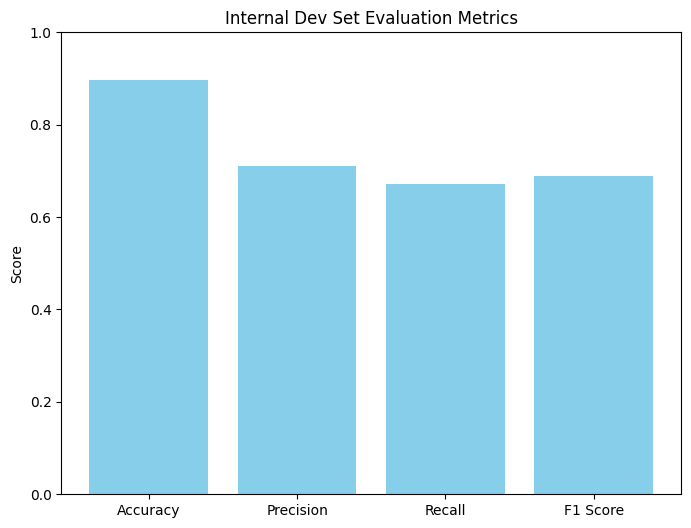

In [78]:
# 2. Test on Validation Dataset
val_preds = model_one_hot.predict(val_seqs, verbose=1)
val_preds = (val_preds > 0.5).astype(np.int32) # np.argmax(test_labels, axis=1)
# print(classification_report(val_labels, val_preds))

import matplotlib.pyplot as plt

# Evaluation Metrics on Test Set
accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds, average='macro')
recall = recall_score(val_labels, val_preds, average='macro')
f1 = f1_score(val_labels, val_preds, average='macro')

print("Dev Set Accuracy:", accuracy)
print("Dev Set Precision:", precision)
print("Dev Set Recall:", recall)
print("Dev Set F1 Score:", f1)
print("\nClassification Report:\n", classification_report(val_labels, val_preds))

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1 }

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Internal Dev Set Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Dev Set Accuracy: 0.89207258834766
Dev Set Precision: 0.676948051948052
Dev Set Recall: 0.6393060288248631
Dev Set F1 Score: 0.6550313049278179

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1895
           1       0.42      0.33      0.37       199

   micro avg       0.89      0.89      0.89      2094
   macro avg       0.68      0.64      0.66      2094
weighted avg       0.88      0.89      0.89      2094
 samples avg       0.89      0.89      0.89      2094



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


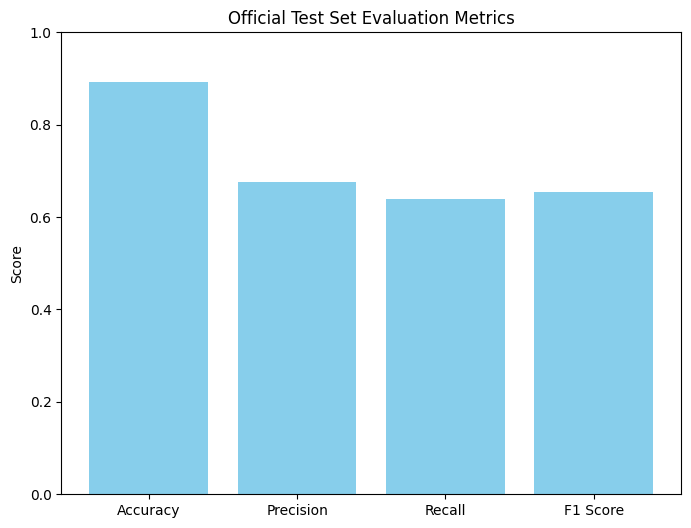

In [79]:
# 3. Test

test_data = np.array(padded_test_emb.tolist())
test_labels = torch.nn.functional.one_hot(torch.tensor(np.array(tokenized_test['label'].tolist())))

test_preds = model_one_hot.predict(test_data, verbose=1)
test_preds = torch.tensor(test_preds > 0.5).float()

# print(classification_report(test_labels, test_preds))

# Evaluation Metrics on Test Set
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds, average='macro')
recall = recall_score(test_labels, test_preds, average='macro')
f1 = f1_score(test_labels, test_preds, average='macro')

print("Dev Set Accuracy:", accuracy)
print("Dev Set Precision:", precision)
print("Dev Set Recall:", recall)
print("Dev Set F1 Score:", f1)
print("\nClassification Report:\n", classification_report(test_labels, test_preds))

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1 }

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Official Test Set Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()

In [114]:
misclassified = {}
for idx, (data, pred, label) in enumerate(zip (test_data, test_preds, test_labels)):
  if (pred != label).all():
    misclassified[idx]=(pred, data, label)
    print('ID', idx, 'has been classified as ', (torch.argmax(pred, dim=0)), 'and should be ', torch.argmax(label, dim=0))

ID 0 has been classified as  tensor(0) and should be  tensor(1)
ID 2 has been classified as  tensor(0) and should be  tensor(1)
ID 4 has been classified as  tensor(0) and should be  tensor(1)
ID 5 has been classified as  tensor(0) and should be  tensor(1)
ID 9 has been classified as  tensor(0) and should be  tensor(1)
ID 10 has been classified as  tensor(0) and should be  tensor(1)
ID 11 has been classified as  tensor(0) and should be  tensor(1)
ID 12 has been classified as  tensor(0) and should be  tensor(1)
ID 13 has been classified as  tensor(0) and should be  tensor(1)
ID 17 has been classified as  tensor(0) and should be  tensor(1)
ID 18 has been classified as  tensor(0) and should be  tensor(1)
ID 19 has been classified as  tensor(0) and should be  tensor(1)
ID 20 has been classified as  tensor(0) and should be  tensor(1)
ID 21 has been classified as  tensor(0) and should be  tensor(1)
ID 22 has been classified as  tensor(0) and should be  tensor(1)
ID 23 has been classified as  

In [109]:
with open("misclassifications_bilstm.txt", "w") as f:
    f.write('ID, Data, Predicted, Label\n')
    for id, (pred, data, label) in misclassified.items():
        f.write(f"{id}, {test_df.iloc[id]['text']}, {torch.argmax(pred, dim=0)}, {torch.argmax(label, dim=0)}\n")
        print(test_df.iloc[id]['text'])
        print("Predicted:", p, "Label:", l)
        print()
f.close()

hopeless: We also know that they can benefit by receiving counseling from someone who can help them understand that their feelings are normal and that their situation is not hopeless ; someone who can help them put their situation in perspective and help them communicate with others who could provide support ; someone knowledgeable about resources they can access ; someone who can help them plan for their needs and the needs of their child by developing either a parenting plan or an adoption plan .
Predicted: 1 Label: 0

refugee: Many refugees do n't want to be resettled anywhere , let alone in the US .
Predicted: 1 Label: 0

homeless: "In a 90-degree view of his constituency , one can see a high rise and a flyover while underneath it , homeless people sleep on pavements . "" As you can see , my constituency is not confined to one socio-economic group , "" he said , adding that apart from water , another major concern for him is to improve the standard of public schools in the area ."
